In [2]:
###Experiment 1: Processed Text
import math
from itertools import islice
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import defaultdict
nltk.download('stopwords')

def preprocess_text(text):
    """Method to clean reviews from noise and standardize text across the different classes.
    The preprocessing includes converting to lowercase, removing punctuation, and removing stopwords.

    Arguments
    ---------
    text : String
        Text to clean

    Returns
    -------
    text : String
        Cleaned text
    """
    import re
    from nltk.corpus import stopwords

    # Initialize the stopwords
    stop_words = set(stopwords.words('english'))

    # Convert to lowercase
    text = text.lower()

    # Remove \n characters
    text = text.replace('\n', ' ')

    # Remove punctuation by replacing them with space
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers by replacing them with space
    text = re.sub(r'\d+', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]



    # Join the words back into a single string
    text = ' '.join(words)

    return text



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:


def create_dataframe(path_to_file):
    """Creates dataframe of reviews and labels.

    Arguments
    ---------
    path_to_file : str
        Path to file to read.

    Returns
    -------
    df : pandas dataframe
        Dataframe of reviews and labels.
    """
    df = {}
    index = 0

    with open(path_to_file, encoding='utf-8') as f:
        for line in f:
            # Assuming the label is at the start of the line in the format __label__1 or __label__2
            label_text, text = line.split(' ', 1)  # Splitting label and review text

            # Assign numeric values for labels (__label__1 -> 0, __label__2 -> 1)
            if label_text == '__label__1':
                label = 0
            elif label_text == '__label__2':
                label = 1
            else:
                continue  # Skip lines with unexpected label formats

            # Preprocess the review text
            text = preprocess_text(text)

            # Create a dictionary with the "label" and "text" keys
            df[index] = {"label": label, "text": text}
            index += 1

    # Convert the dictionary to a pandas DataFrame
    return pd.DataFrame.from_dict(df, orient='index')

# Example usage:
df_train = create_dataframe(r'/content/drive/MyDrive/NLP_DATASET/train.ft.txt')
df_test = create_dataframe(r'/content/drive/MyDrive/NLP_DATASET/test.ft.txt')




In [9]:
def vocab_dictionary(df):
    """ Creates dictionary of frequencies based on a dataset of reviews.

    Arguments
    ---------
    df : pandas DataFrame
        DataFrame containing a column of reviews.

    Returns
    -------
    vocab_dict : dictionary
        Dictionary of words and their frequencies with the format {word: frequency}.
    """
    # Create an empty defaultdict to store word frequencies
    vocab = defaultdict(int)

    # Iterate through the reviews in the DataFrame
    for review in df['text']:
        words = review.split()  # Split the text into words
        for word in words:
            vocab[word] += 1  # Increment the word's frequency

    return dict(vocab)  # Convert defaultdict to a regular dictionary


full_vocab = vocab_dictionary(df_train)

# positive vocab to keep track of words in positive reviews
positive_vocab = vocab_dictionary(df_train[df_train['label'] == 1])

# negative vocab to keep track of words in negative reviews
negative_vocab = vocab_dictionary(df_train[df_train['label'] == 0])





In [10]:

#sort full_vocab from words with high frequency to low frequency
vocab_sorted = dict(sorted(full_vocab.items(), key=lambda item: item[1], reverse=True))

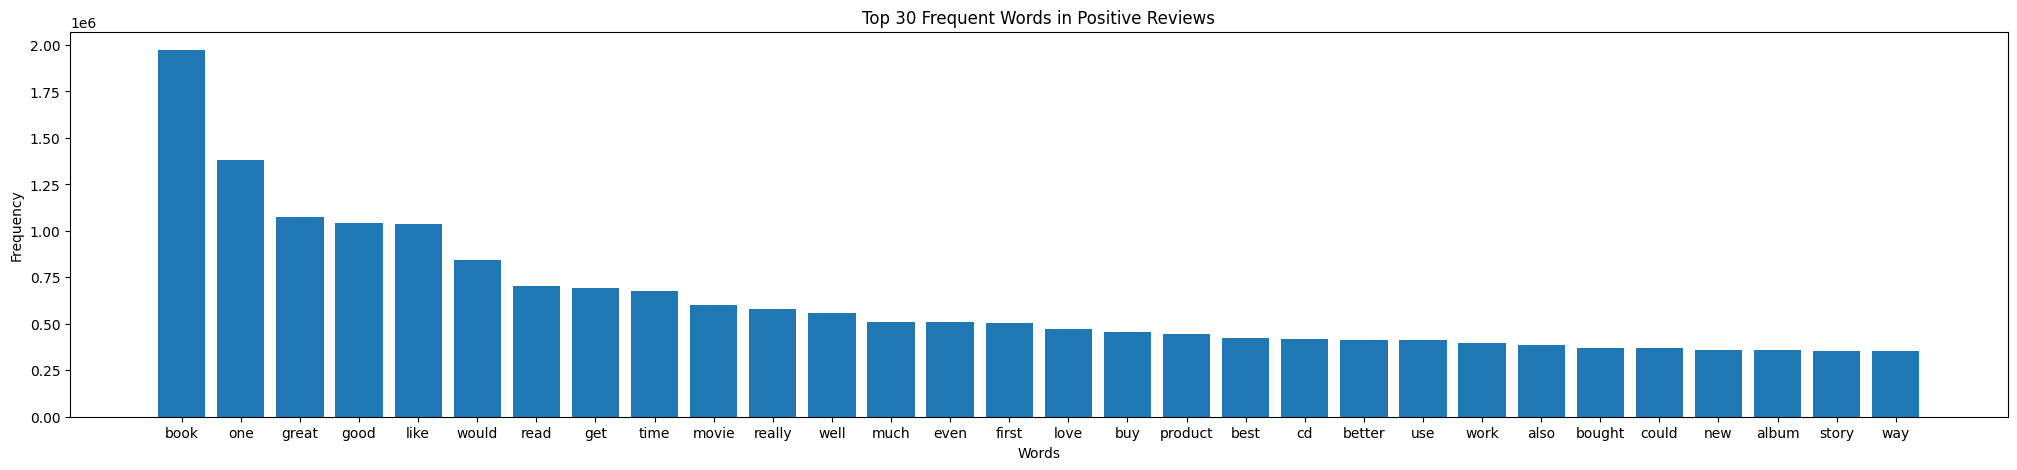

Vocabulary size: 884645


In [11]:

#Take first 30 tokens of each vocabulary

first_tokens = list(islice(vocab_sorted.items(), 30))


positive_vocab = vocab_dictionary(df_train[df_train['label'] == 1])

fig = plt.figure(figsize=(25, 5))
plt.bar(*zip(*first_tokens))
plt.title("Top 30 Frequent Words in Positive Reviews")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()
print('Vocabulary size:',len(full_vocab))

In [12]:
positive_prior = len(df_train[df_train['label'] == 1]) / len(df_train)
negative_prior = len(df_train[df_train['label'] == 0]) / len(df_train)

# New Section

In [14]:


SMOOTHING_FACTOR = 1.8
def calculate_log_likelihood(vocab, positive_vocab, negative_vocab, smoothing_factor=SMOOTHING_FACTOR):
    """Calculates log likelihood of words belonging to a positive or negative review.

    Arguments
    ---------
    vocab : dictionary
        Vocabulary of words in the dataset with their respective frequencies.
    positive_vocab : dictionary
        Vocabulary of words in the positive reviews with their frequencies.
    negative_vocab : dictionary
        Vocabulary of words in the negative reviews with their frequencies.
    smoothing_factor : float
        Smoothing factor to account for unseen words.

    Returns
    -------
    likelihood : dictionary of dictionaries
        Dictionary of words and their positive and negative log likelihoods.
    """
    likelihood = {}

    # Total number of words in positive and negative vocabularies
    number_instances_positive = sum(positive_vocab.values())
    number_instances_negative = sum(negative_vocab.values())

    # Number of unique words in the entire vocabulary (for smoothing)
    number_types = len(vocab)

    for word, count in vocab.items():
        likelihood[word] = {}

        # Frequency of the word in positive and negative reviews (with smoothing)
        freq_positive = positive_vocab.get(word, 0) + smoothing_factor
        freq_negative = negative_vocab.get(word, 0) + smoothing_factor

        # Calculate log likelihood for positive and negative classes
        likelihood[word]['positive'] = math.log(freq_positive / (number_instances_positive + smoothing_factor * number_types))
        likelihood[word]['negative'] = math.log(freq_negative / (number_instances_negative + smoothing_factor * number_types))

    return likelihood




In [15]:

likelihood = calculate_log_likelihood(full_vocab, positive_vocab, negative_vocab)
assert  round(sum([math.exp(likelihood[word]['positive']) for word in likelihood]))==1 , "There is probably a bug calculating the positive log likelihood"
assert  round(sum([math.exp(likelihood[word]['negative']) for word in likelihood]))==1 , "There is probably a bug calculating the negative log likelihood"
print("Great job! Keep going!")

Great job! Keep going!


In [16]:


def classify_review(text, likelihood, positive_prior, negative_prior):
    """Calculates log scores for a new text given some prior probabilities and likelihoods.

    Arguments
    ---------
    text : string
        Text to classify.
    likelihood : dictionary
        Dictionary of words and their log likelihoods for positive and negative reviews.
    positive_prior : float
        Prior probability of a review being positive.
    negative_prior : float
        Prior probability of a review being negative.

    Returns
    -------
    predicted_sentiment : string
        Predicted sentiment of the text.
    sentiment_scores : dictionary
        Dictionary of positive and negative sentiment scores.
    """
    # Preprocess the input review (same as training preprocessing)
    tokens = preprocess_text(text).split()

    # Initialize the log scores with the log of the priors
    log_score_positive = math.log(positive_prior)
    log_score_negative = math.log(negative_prior)

    # Calculate log scores for each token
    for token in tokens:
        if token in likelihood:
            # Add the log likelihoods if the token exists in the likelihood dictionary
            log_score_positive += likelihood[token]['positive']
            log_score_negative += likelihood[token]['negative']


    # Prepare sentiment scores
    sentiment_scores = {
        'positive': log_score_positive,
        'negative': log_score_negative,
    }

    # Determine the predicted sentiment based on the highest score
    if log_score_positive > log_score_negative:
        predicted_sentiment = 'positive'
    else:
        predicted_sentiment = 'negative'

    return predicted_sentiment, sentiment_scores


In [17]:
text="This hair dryer is terribly bad, it doesn't work at all"
predicted_sentiment, sentiment_scores = classify_review(text, likelihood,
                               positive_prior, negative_prior)

print("Predicted Sentiment:", predicted_sentiment)
print("Sentiment Scores:",sentiment_scores)
#You should see here a correct prediction of negative

Predicted Sentiment: negative
Sentiment Scores: {'positive': -42.488681080766554, 'negative': -39.01136970800271}


In [18]:

# Initialize counters for true positives, false positives, true negatives, and false negatives
true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0


# Iterate through the test set, classify each review, and compare to true label
for index, review in df_test.iterrows():
    true_label = review['label']
    text = review['text']


    predicted_sentiment, _ = classify_review(text, likelihood, positive_prior, negative_prior)

    # Convert predicted sentiment ('positive' or 'negative') to 1 or 0
    predicted_label = 1 if predicted_sentiment == 'positive' else 0

    # Update the confusion matrix
    if true_label == 1 and predicted_label == 1:
        true_positives += 1
    elif true_label == 1 and predicted_label == 0:
        false_negatives += 1
    elif true_label == 0 and predicted_label == 0:
        true_negatives += 1
    elif true_label == 0 and predicted_label == 1:
        false_positives += 1

# Calculate precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Output the metrics
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  0.85592024492998
Recall:  0.84009
F1 Score:  0.8479312441805597


In [20]:
#experiment-2:(Raw Text)

def create_dataframe(path_to_file, preprocess=True):

    df = {}
    index = 0

    with open(path_to_file, encoding='utf-8') as f:
        for line in f:
            label_text, text = line.split(' ', 1)

            if label_text == '__label__1':
                label = 0
            elif label_text == '__label__2':
                label = 1
            else:
                continue

            # Only preprocess if requested
            if preprocess:
                text = preprocess_text(text)

            df[index] = {"label": label, "text": text.strip()}
            index += 1

    return pd.DataFrame.from_dict(df, orient='index')

# Raw training and test data
df_train_raw = create_dataframe(r'/content/drive/MyDrive/NLP_DATASET/train.ft.txt', preprocess=False)
df_test_raw = create_dataframe(r'/content/drive/MyDrive/NLP_DATASET/test.ft.txt', preprocess=False)




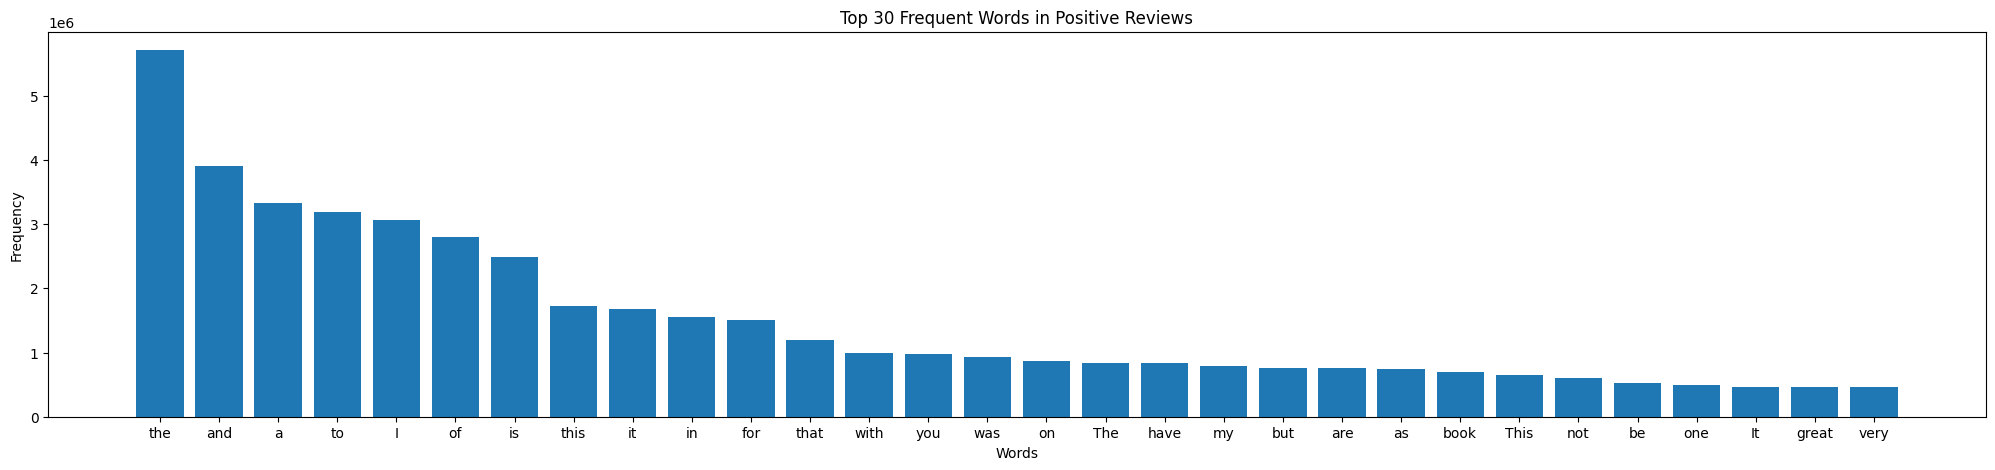

Vocabulary size (Raw): 5165172


In [21]:
def vocab_dictionary(df):

    vocab = defaultdict(int)

    for review in df['text']:
        words = review.split()
        for word in words:
            vocab[word] += 1

    return dict(vocab)

# Build vocabularies for raw data
full_vocab_raw = vocab_dictionary(df_train_raw)
positive_vocab_raw = vocab_dictionary(df_train_raw[df_train_raw['label'] == 1])
negative_vocab_raw = vocab_dictionary(df_train_raw[df_train_raw['label'] == 0])


# Corrected code for positive reviews
vocab_sorted_positive = dict(sorted(positive_vocab_raw.items(), key=lambda item: item[1], reverse=True))
first_tokens_positive = list(islice(vocab_sorted_positive.items(), 30))


positive_vocab_raw = vocab_dictionary(df_train_raw[df_train_raw['label'] == 1])

fig = plt.figure(figsize=(25, 5))
plt.bar(*zip(*first_tokens_positive))  # Use the first 30 tokens
plt.title("Top 30 Frequent Words in Positive Reviews")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

print("Vocabulary size (Raw):", len(full_vocab_raw))




In [23]:
positive_prior_raw = len(df_train_raw[df_train_raw['label'] == 1]) / len(df_train_raw)
negative_prior_raw = len(df_train_raw[df_train_raw['label'] == 0]) / len(df_train_raw)


In [27]:
SMOOTHING_FACTOR = 3

def calculate_log_likelihood_raw(vocab, positive_vocab_raw, negative_vocab_raw, smoothing_factor=SMOOTHING_FACTOR):
    likelihood = {}

    number_instances_positive = sum(positive_vocab_raw.values())
    number_instances_negative = sum(negative_vocab_raw.values())
    number_types = len(vocab)

    for word in vocab:
        likelihood[word] = {}

        freq_positive = positive_vocab_raw.get(word, 0) + smoothing_factor
        freq_negative = negative_vocab_raw.get(word, 0) + smoothing_factor

        likelihood[word]['positive'] = math.log(freq_positive / (number_instances_positive + smoothing_factor * number_types))
        likelihood[word]['negative'] = math.log(freq_negative / (number_instances_negative + smoothing_factor * number_types))

    return likelihood


In [28]:

# Calculate likelihoods for raw data
likelihood_raw = calculate_log_likelihood_raw(full_vocab_raw, positive_vocab_raw, negative_vocab_raw)
assert  round(sum([math.exp(likelihood_raw[word]['positive']) for word in likelihood_raw]))==1 , "There is probably a bug calculating the positive log likelihood"
assert  round(sum([math.exp(likelihood_raw[word]['negative']) for word in likelihood_raw]))==1 , "There is probably a bug calculating the negative log likelihood"
print("Great job! Keep going!")


Great job! Keep going!


In [29]:



def classify_review_raw(text,likelihood_raw,positive_prior_raw,negative_prior_raw):
    tokens = text.split()

    log_score_positive = math.log(positive_prior_raw)
    log_score_negative = math.log(negative_prior_raw)

    for token in tokens:
        if token in likelihood_raw:
            log_score_positive += likelihood_raw[token]['positive']
            log_score_negative += likelihood_raw[token]['negative']


    sentiment_scores = {
        'positive': log_score_positive,
        'negative': log_score_negative,
    }

    predicted_sentiment = 'positive' if log_score_positive > log_score_negative else 'negative'

    return predicted_sentiment, sentiment_scores




In [30]:
text = "This hair dryer is terribly bad, it doesn't work at all"
predicted_sentiment, sentiment_scores = classify_review_raw(text, likelihood_raw, positive_prior_raw,negative_prior_raw)

print("Predicted Sentiment (Raw):", predicted_sentiment)
print("Sentiment Scores (Raw):", sentiment_scores)


Predicted Sentiment (Raw): negative
Sentiment Scores (Raw): {'positive': -84.24093076898068, 'negative': -80.35179200150974}


In [31]:
true_positives_raw = 0
false_positives_raw = 0
true_negatives_raw = 0
false_negatives_raw = 0


for index, review in df_test_raw.iterrows():
    true_label = review['label']
    text = review['text']

    predicted_sentiment, _ = classify_review_raw(text, likelihood_raw, positive_prior_raw, negative_prior_raw)
    predicted_label = 1 if predicted_sentiment == 'positive' else 0

    # Update counters
    if true_label == 1 and predicted_label == 1:
        true_positives_raw += 1
    elif true_label == 1 and predicted_label == 0:
        false_negatives_raw += 1
    elif true_label == 0 and predicted_label == 0:
        true_negatives_raw += 1
    elif true_label == 0 and predicted_label == 1:
        false_positives_raw += 1

precision_raw = true_positives_raw / (true_positives_raw + false_positives_raw) if (true_positives_raw + false_positives_raw) > 0 else 0
recall_raw = true_positives_raw / (true_positives_raw + false_negatives_raw) if (true_positives_raw + false_negatives_raw) > 0 else 0
f1_score_raw = 2 * (precision_raw * recall_raw) / (precision_raw + recall_raw) if (precision_raw + recall_raw) > 0 else 0

print("Metrics for Raw Data:")
print("Precision:", precision_raw)
print("Recall:", recall_raw)
print("F1 Score:", f1_score_raw)


Metrics for Raw Data:
Precision: 0.8876335359579051
Recall: 0.83671
F1 Score: 0.8614198277592748


In [32]:
#Experiment 3: Removing Rare Words

from collections import defaultdict

def count_word_frequencies(df):

    word_freq = defaultdict(int)

    # Iterate through the text data and count the occurrences of each word
    for review in df['text']:
        words = review.split()  # Split the review into words
        for word in words:
            word_freq[word] += 1  # Increment word frequency

    return word_freq

# Get the word frequencies from the training dataset
word_frequencies = count_word_frequencies(df_train)

# Set a threshold for rare words (e.g., less than 5 occurrences)
threshold = 5

# Identify the rare words that occur less than the threshold
rare_words = {word for word, count in word_frequencies.items() if count < threshold}
print(f"Number of rare words (below {threshold} occurrences):", len(rare_words))


Number of rare words (below 5 occurrences): 701708


In [33]:
def remove_rare_words(text, rare_words):

    words = text.split()  # Split the text into words
    filtered_words = [word for word in words if word not in rare_words]  # Remove rare words
    cleaned_text = ' '.join(filtered_words)  # Join the words back into a single string
    return cleaned_text

# Apply the removal of rare words to the entire dataset
df_train['cleaned_text'] = df_train['text'].apply(lambda text: remove_rare_words(text, rare_words))

# Display a sample of cleaned text
print(df_train['cleaned_text'].head())


0    stuning even non gamer sound track beautiful p...
1    best soundtrack ever anything reading lot revi...
2    amazing soundtrack favorite music time hands i...
3    excellent soundtrack truly like soundtrack enj...
4    remember pull jaw floor hearing played game kn...
Name: cleaned_text, dtype: object


In [34]:
# Retrain the model using the cleaned text (without rare words)
def vocab_dictionary(df):


    vocab = defaultdict(int)

    # Iterate through the cleaned reviews in the DataFrame
    for review in df['cleaned_text']:
        words = review.split()  # Split the text into words
        for word in words:
            vocab[word] += 1  # Increment word frequency

    return dict(vocab)  # Convert defaultdict to a regular dictionary

# Build the vocabulary for the filtered text
filtered_vocab = vocab_dictionary(df_train)

# Create positive and negative vocabularies based on the cleaned text
positive_vocab = vocab_dictionary(df_train[df_train['label'] == 1])
negative_vocab = vocab_dictionary(df_train[df_train['label'] == 0])

# Proceed with the training process and log-likelihood calculations as before
likelihood = calculate_log_likelihood(filtered_vocab, positive_vocab, negative_vocab)


In [35]:
text="This hair dryer is terribly bad, it doesn't work at all"
predicted_sentiment, sentiment_scores = classify_review(text, likelihood,
                               positive_prior, negative_prior)

print("Predicted Sentiment:", predicted_sentiment)
print("Sentiment Scores:",sentiment_scores)
#You should see here a correct prediction of negative

Predicted Sentiment: negative
Sentiment Scores: {'positive': -42.37483737733652, 'negative': -38.910093961029666}


In [36]:
# Evaluate the model on the test set
true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

# Iterate through the test set and classify the reviews
for index, review in df_test.iterrows():
    true_label = review['label']
    text = remove_rare_words(review['text'], rare_words)  # Remove rare words from the test data

    # Classify the review using the model trained on cleaned text
    predicted_sentiment, _ = classify_review(text, likelihood, positive_prior, negative_prior)

    # Convert predicted sentiment ('positive' or 'negative') to 1 or 0
    predicted_label = 1 if predicted_sentiment == 'positive' else 0

    # Update the confusion matrix
    if true_label == 1 and predicted_label == 1:
        true_positives += 1
    elif true_label == 1 and predicted_label == 0:
        false_negatives += 1
    elif true_label == 0 and predicted_label == 0:
        true_negatives += 1
    elif true_label == 0 and predicted_label == 1:
        false_positives += 1

# Calculate precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Output the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: 0.8539942949500682
Recall: 0.84276
F1 Score: 0.8483399560609911


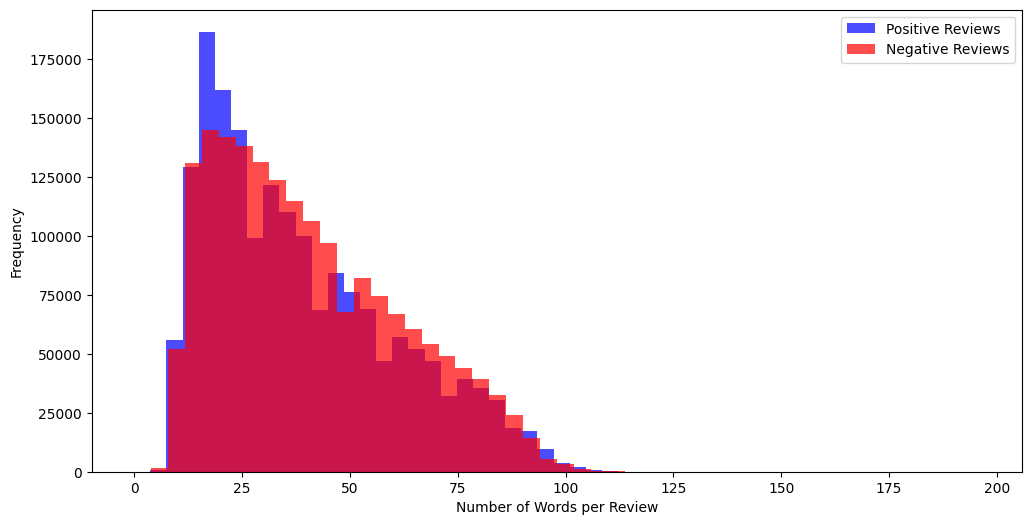

In [38]:
## Experiment 4: Impact of Sentiment on Review Lengths

import matplotlib.pyplot as plt
df_train['review_length'] = df_train['text'].apply(lambda x: len(x.split()))
positive_reviews = df_train[df_train['label'] == 1]['review_length']
negative_reviews = df_train[df_train['label'] == 0]['review_length']
plt.figure(figsize=(12, 6))
plt.hist(positive_reviews, bins=50, alpha=0.7, label='Positive Reviews', color='blue')
plt.hist(negative_reviews, bins=50, alpha=0.7, label='Negative Reviews', color='red')
plt.xlabel("Number of Words per Review")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()
